# Definição de Combined_metric

**Dado**

* Colunas lexicais: $L_i$, $i=1,\dots,n_{\rm lex}$
* Colunas semânticas: $S_j$, $j=1,\dots,n_{\rm sem}$
* Pesos internos:

  $$
    A1_i\quad\text{para cada }L_i,\quad\sum_{i=1}^{n_{\rm lex}}A1_i = 1,
  $$
  $$
    A2_j\quad\text{para cada }S_j,\quad\sum_{j=1}^{n_{\rm sem}}A2_j = 1
  $$
* Pesos globais $B1, B2$:

  $$
   B_1 + B_2 = 1
  $$

**1. Cálculo dos scores parciais**

$$
\begin{aligned}
\text{lexical\_score}
&= \sum_{i=1}^{n_{\rm lex}} A1_i \;L_i,\\
\text{semantic\_score}
&= \sum_{j=1}^{n_{\rm sem}} A2_j \;S_j.
\end{aligned}
$$

**2. Combinação final**

$$
\text{combined\_metric}
= B_1 \,\times\, \text{lexical\_score}
\;+\;
B_2 \,\times\, \text{semantic\_score}.
$$

---

# Gerando Base Agg Frame

In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import research.src.functions as functions
import research.src.constants as constants 

In [11]:
avg_summeval_metrics,df_agg = functions.get_agg_frame(n=50,cache=True,save=True,only_cached=False)

100%|██████████| 550/550 [13:44<00:00,  1.50s/it]


In [64]:
df_agg.shape

(80, 11)

## Visualizando Corr com pesos básicos

In [16]:
functions.get_final_corr(avg_summeval_metrics,df_agg)

np.float64(0.21311662917522423)

## Testando pesos customizados

Aqui vamos só checar o tamanho dos vetores de A1 e A2 

In [17]:
lexical_cols, semantic_cols = functions.get_metric_columns(df_agg)
# 2) Inicializa A1 e A2 com pesos iguais, se não fornecidos
n_lex = len(lexical_cols)
n_sem = len(semantic_cols)
print(f"n_lex: {n_lex}, n_sem: {n_sem}")

n_lex: 3, n_sem: 3


In [18]:
A1 = [.2,.3,.5]
A2 = [.2,.2,.6]
B1 = .3
B2 = .7

In [19]:
teste = functions.get_final_corr(avg_summeval_metrics,df_agg,A1=A1,A2=A2,B1=B1,B2=B2)

In [20]:
teste

np.float64(0.21722360088601203)

# Criando Study - Optuna

In [21]:
import optuna
import pandas as pd
from functools import partial
import src.model as model

## Definindo minha função Objetivo

In [27]:
objective_fn = partial(
    model.objective,
    avg_summeval_metrics=avg_summeval_metrics,
    df_agg=df_agg
)

In [28]:
study = optuna.create_study(direction="maximize")

[I 2025-05-07 17:06:29,431] A new study created in memory with name: no-name-171c265a-3f1e-41be-a08a-a0ca733c0150


In [29]:
study.optimize(objective_fn, n_trials=1000) 

[I 2025-05-07 17:06:29,943] Trial 0 finished with value: 0.2232784506082021 and parameters: {'A1_0': 0.5039036304620887, 'A1_1': 0.0134800680782452, 'A1_2': 0.7912459178563601, 'A2_0': 0.25381220785598024, 'A2_1': 0.5976574560190376, 'A2_2': 0.29693131699288744, 'B1': 0.8312393516985694, 'B2': 0.7507394191418688}. Best is trial 0 with value: 0.2232784506082021.
[I 2025-05-07 17:06:29,993] Trial 1 finished with value: 0.2134921237316391 and parameters: {'A1_0': 0.5392979452055208, 'A1_1': 0.3041421582752656, 'A1_2': 0.8543072165935198, 'A2_0': 0.15843491090501016, 'A2_1': 0.4765351964518244, 'A2_2': 0.2139357931441077, 'B1': 0.9402609352292721, 'B2': 0.883080623933228}. Best is trial 0 with value: 0.2232784506082021.
[I 2025-05-07 17:06:30,036] Trial 2 finished with value: 0.20513736985140787 and parameters: {'A1_0': 0.14636123505426557, 'A1_1': 0.6344597010158853, 'A1_2': 0.6462946812226181, 'A2_0': 0.07986508536016945, 'A2_1': 0.46065551313102115, 'A2_2': 0.926584715084089, 'B1': 0.69

## Analisando meu Estudo

In [68]:
model.get_best_weights(study,df_agg)


🧪 Resultado do Otimização de Pesos
───────────────────────────────────
▶️ Pesos Lexicais (A1):
    • lexical_rouge1_f1   : 0.820
    • lexical_rougeL_f1   : 0.000
    • lexical_bleu        : 0.179

▶️ Pesos Semânticos (A2):
    • semantic_bert_score_precision: 0.234
    • semantic_bert_score_recall: 0.532
    • semantic_bert_score_f1: 0.234

▶️ Pesos Globais (B1 e B2):
    • B1: 0.343
    • B2: 0.657

▶️ Melhor correlação (objetivo):
    0.254



In [32]:
from plotly.io import show


fig = optuna.visualization.plot_parallel_coordinate(study, params=study.best_params.keys())
show(fig)

# Comparativo Final

Voltar e trazer comparativo do df_agg só que pontual e com os melhores pesos definidos pelo OPTUNA

In [43]:
A1_best_params = [v for c,v in study.best_params.items() if c.startswith("A1")]
A2_best_params = [v for c,v in study.best_params.items() if c.startswith("A2")]
B1_best_param = study.best_params["B1"]
B2_best_param = study.best_params["B2"]

In [48]:
comparative_metrics_frame = functions.get_combinated_metric(avg_summeval_metrics, df_agg, constants.JOIN_COLS,
                                                            A1_best_params,A2_best_params,B1_best_param,B2_best_param)
correlation_table_best_param = functions.get_corr(comparative_metrics_frame, constants.EVAL_COLS, constants.HUMAN_COLS,  constants.METHODS)

In [49]:
correlation_table_best_param.tail()

,exp_coherence,exp_consistency,exp_fluency,exp_relevance,exp_overall_mean
semantic_bert_score_precision,0.146766,0.058911,-0.100914,0.401860,0.205243
semantic_bert_score_recall,0.286609,0.110958,0.008452,0.232284,0.176752
semantic_bert_score_f1,0.263695,0.105425,-0.049613,0.329372,0.209796
semantic_overall_mean,0.262811,0.105681,-0.049613,0.331776,0.210735
hybrid_quality_score,0.271243,0.098544,-0.053194,0.338239,0.238040


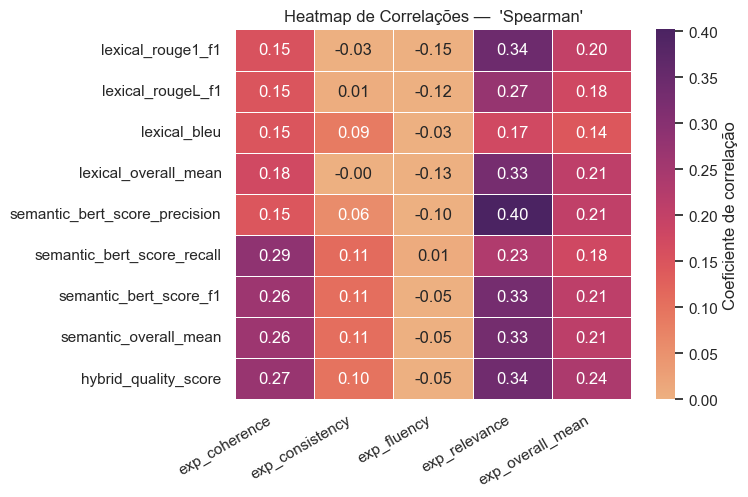

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", palette="flare")  # ou 'rocket', 'mako'…

ax = sns.heatmap(
    correlation_table_best_param,          # seu DataFrame
    cmap="flare",                          # mesma paleta do set_theme
    annot=True,                            # escreve os números na célula
    fmt=".2f",                             # arredonda para 2 casas decimais
    vmin=0,# vmax=0.4,                   # (opcional) mantém a escala coerente
    cbar_kws={"label": "Coeficiente de correlação"},
    linewidths=0.5                         # finas linhas divisórias
)
ax.set_title(f"Heatmap de Correlações —  '{constants.METHODS[0].title()}'")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


plt.show()